# AAI-521 Final Project – Group 3  
## 02 – Preprocessing and Vehicle Cropping

**Goal:**  
Convert UA-DETRAC sequences into a compact vehicle classification dataset by:

- Iterating over training sequences
- Cropping each annotated vehicle
- Resizing crops to a fixed resolution
- Encoding classes as integer labels
- Saving the resulting dataset to disk for later model training

This notebook **produces the training dataset** used by the CNN model.

#### Imports & Configuration

In [ ]:
import os
import sys
from pathlib import Path
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
import matplotlib.pyplot as plt

PROJECT_ROOT = Path().resolve().parent
DATA_ROOT = PROJECT_ROOT / "data"

IMAGES_ROOT = DATA_ROOT / "DETRAC-Images"
TRAIN_ANN_ROOT = DATA_ROOT / "DETRAC-Train-Annotations"

TARGET_SIZE = (64, 64)  # (width, height) for CNN inputs
OUTPUT_PATH = PROJECT_ROOT / "outputs" / "cropped_vehicle_dataset.npz"
SRC_DIR = PROJECT_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils_detrac import load_detrac_annotations, VehicleClassifier, predict_vehicle_class

print("Images root:", IMAGES_ROOT)
print("Train annotations root:", TRAIN_ANN_ROOT)
print("Output dataset path:", OUTPUT_PATH)

Images root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Images
Train annotations root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Train-Annotations
Output dataset path: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/outputs/cropped_vehicle_dataset.npz


## 1. Generate Cropped Vehicle Dataset

We iterate over all training XML files, match them to image folders,
and generate:

- `images`: array of shape `(N, H, W, 3)` in `[0, 1]` range
- `labels`: integer class IDs
- `class_to_idx`: mapping from vehicle type string → integer

The resulting arrays are saved to `cropped_vehicle_dataset.npz`.

#### Dataset Generation Function

In [3]:
def generate_cnn_training_dataset(
    annotations_root: Path,
    images_root: Path,
    target_size=TARGET_SIZE,
):

    all_images = []
    all_labels = []
    all_metadata = []

    class_to_idx = {}
    next_class_idx = 0

    xml_files = sorted(
        f for f in annotations_root.iterdir()
        if f.suffix.lower() == ".xml"
    )

    for xml_path in tqdm(xml_files, desc="Sequences"):
        seq_id = xml_path.stem  # e.g., "MVI_20011"
        seq_images_dir = images_root / seq_id
        if not seq_images_dir.exists():
            print(f"[WARN] No image folder for {seq_id}, skipping.")
            continue

        annotations = load_detrac_annotations(xml_path)

        for frame_num, targets in annotations.items():
            img_file = seq_images_dir / f"img{frame_num:05d}.jpg"
            if not img_file.exists():
                continue

            frame = cv2.imread(str(img_file))
            if frame is None:
                continue

            h_img, w_img = frame.shape[:2]

            for t in targets:
                x, y, w, h = t["bbox"]
                cls = t["class"]

                # Clamp bounding box to image bounds
                x1 = max(int(x), 0)
                y1 = max(int(y), 0)
                x2 = min(int(x + w), w_img)
                y2 = min(int(y + h), h_img)

                if x2 <= x1 or y2 <= y1:
                    continue

                crop = frame[y1:y2, x1:x2]
                crop = cv2.resize(crop, target_size)
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                crop = crop.astype("float32") / 255.0

                if cls not in class_to_idx:
                    class_to_idx[cls] = next_class_idx
                    next_class_idx += 1

                label_idx = class_to_idx[cls]

                all_images.append(crop)
                all_labels.append(label_idx)
                all_metadata.append({
                    "seq_id": seq_id,
                    "frame_num": frame_num,
                    "class": cls,
                })

    images = np.stack(all_images, axis=0)
    labels = np.array(all_labels, dtype=np.int64)

    print("Dataset size:", images.shape[0])
    print("Classes:", class_to_idx)

    return images, labels, class_to_idx, all_metadata

#### Run Generation & Save

In [4]:
images, labels, class_to_idx, metadata = generate_cnn_training_dataset(
    TRAIN_ANN_ROOT,
    IMAGES_ROOT,
    target_size=TARGET_SIZE,
)

np.savez_compressed(
    OUTPUT_PATH,
    images=images,
    labels=labels,
    class_to_idx=class_to_idx,
    metadata=np.array(metadata, dtype=object),
)

print(f"Saved cropped dataset to {OUTPUT_PATH}")

Sequences:   0%|          | 0/60 [00:00<?, ?it/s]

Loaded annotations for 664 frames from MVI_20011.xml


Sequences:   2%|▏         | 1/60 [00:01<01:09,  1.18s/it]

Loaded annotations for 936 frames from MVI_20012.xml


Sequences:   3%|▎         | 2/60 [00:02<01:21,  1.41s/it]

Loaded annotations for 437 frames from MVI_20032.xml


Sequences:   5%|▌         | 3/60 [00:03<00:58,  1.03s/it]

Loaded annotations for 784 frames from MVI_20033.xml


Sequences:   7%|▋         | 4/60 [00:04<00:59,  1.07s/it]

Loaded annotations for 800 frames from MVI_20034.xml


Sequences:   8%|▊         | 5/60 [00:05<01:03,  1.15s/it]

Loaded annotations for 800 frames from MVI_20035.xml


Sequences:  10%|█         | 6/60 [00:07<01:05,  1.22s/it]

Loaded annotations for 906 frames from MVI_20051.xml


Sequences:  12%|█▏        | 7/60 [00:08<01:08,  1.29s/it]

Loaded annotations for 694 frames from MVI_20052.xml


Sequences:  13%|█▎        | 8/60 [00:09<01:05,  1.26s/it]

Loaded annotations for 800 frames from MVI_20061.xml


Sequences:  15%|█▌        | 9/60 [00:11<01:05,  1.28s/it]

Loaded annotations for 800 frames from MVI_20062.xml


Sequences:  17%|█▋        | 10/60 [00:12<01:02,  1.26s/it]

Loaded annotations for 800 frames from MVI_20063.xml


Sequences:  18%|█▊        | 11/60 [00:13<01:00,  1.24s/it]

Loaded annotations for 800 frames from MVI_20064.xml


Sequences:  20%|██        | 12/60 [00:14<01:03,  1.32s/it]

Loaded annotations for 1200 frames from MVI_20065.xml


Sequences:  22%|██▏       | 13/60 [00:17<01:15,  1.60s/it]

Loaded annotations for 1323 frames from MVI_39761.xml


Sequences:  23%|██▎       | 14/60 [00:18<01:15,  1.65s/it]

Loaded annotations for 570 frames from MVI_39771.xml


Sequences:  25%|██▌       | 15/60 [00:19<01:01,  1.37s/it]

Loaded annotations for 1861 frames from MVI_39781.xml


Sequences:  27%|██▋       | 16/60 [00:22<01:14,  1.70s/it]

Loaded annotations for 885 frames from MVI_39801.xml


Sequences:  28%|██▊       | 17/60 [00:23<01:06,  1.55s/it]

Loaded annotations for 500 frames from MVI_39811.xml


Sequences:  30%|███       | 18/60 [00:24<00:53,  1.28s/it]

Loaded annotations for 880 frames from MVI_39821.xml


Sequences:  32%|███▏      | 19/60 [00:25<00:51,  1.26s/it]

Loaded annotations for 1286 frames from MVI_39851.xml


Sequences:  33%|███▎      | 20/60 [00:27<00:58,  1.46s/it]

Loaded annotations for 745 frames from MVI_39861.xml


Sequences:  35%|███▌      | 21/60 [00:28<00:53,  1.37s/it]

Loaded annotations for 1082 frames from MVI_39931.xml


Sequences:  37%|███▋      | 22/60 [00:29<00:55,  1.46s/it]

Loaded annotations for 1645 frames from MVI_40131.xml


Sequences:  38%|███▊      | 23/60 [00:32<01:09,  1.89s/it]

Loaded annotations for 1600 frames from MVI_40141.xml


Sequences:  40%|████      | 24/60 [00:35<01:15,  2.11s/it]

Loaded annotations for 1746 frames from MVI_40152.xml


Sequences:  42%|████▏     | 25/60 [00:38<01:18,  2.24s/it]

Loaded annotations for 1490 frames from MVI_40161.xml


Sequences:  43%|████▎     | 26/60 [00:40<01:17,  2.27s/it]

Loaded annotations for 1726 frames from MVI_40162.xml


Sequences:  45%|████▌     | 27/60 [00:43<01:20,  2.43s/it]

Loaded annotations for 1150 frames from MVI_40171.xml


Sequences:  47%|████▋     | 28/60 [00:45<01:14,  2.32s/it]

Loaded annotations for 2635 frames from MVI_40172.xml


Sequences:  48%|████▊     | 29/60 [00:49<01:32,  2.99s/it]

Loaded annotations for 1700 frames from MVI_40181.xml


Sequences:  50%|█████     | 30/60 [00:52<01:25,  2.86s/it]

Loaded annotations for 2495 frames from MVI_40191.xml


Sequences:  52%|█████▏    | 31/60 [00:57<01:38,  3.41s/it]

Loaded annotations for 2195 frames from MVI_40192.xml


Sequences:  53%|█████▎    | 32/60 [01:00<01:39,  3.54s/it]

Loaded annotations for 925 frames from MVI_40201.xml


Sequences:  55%|█████▌    | 33/60 [01:02<01:19,  2.95s/it]

Loaded annotations for 1225 frames from MVI_40204.xml


Sequences:  57%|█████▋    | 34/60 [01:04<01:11,  2.74s/it]

Loaded annotations for 1923 frames from MVI_40211.xml


Sequences:  58%|█████▊    | 35/60 [01:07<01:11,  2.86s/it]

Loaded annotations for 1690 frames from MVI_40212.xml


Sequences:  60%|██████    | 36/60 [01:10<01:07,  2.81s/it]

Loaded annotations for 1782 frames from MVI_40213.xml


Sequences:  62%|██████▏   | 37/60 [01:13<01:04,  2.80s/it]

Loaded annotations for 2320 frames from MVI_40241.xml


Sequences:  63%|██████▎   | 38/60 [01:17<01:07,  3.09s/it]

Loaded annotations for 1265 frames from MVI_40243.xml


Sequences:  65%|██████▌   | 39/60 [01:19<00:58,  2.79s/it]

Loaded annotations for 1345 frames from MVI_40244.xml


Sequences:  67%|██████▋   | 40/60 [01:21<00:52,  2.61s/it]

Loaded annotations for 2120 frames from MVI_40732.xml


Sequences:  68%|██████▊   | 41/60 [01:24<00:53,  2.83s/it]

Loaded annotations for 1145 frames from MVI_40751.xml


Sequences:  70%|███████   | 42/60 [01:26<00:45,  2.52s/it]

Loaded annotations for 2025 frames from MVI_40752.xml


Sequences:  72%|███████▏  | 43/60 [01:29<00:45,  2.70s/it]

Loaded annotations for 1720 frames from MVI_40871.xml


Sequences:  73%|███████▎  | 44/60 [01:33<00:48,  3.00s/it]

Loaded annotations for 1875 frames from MVI_40962.xml


Sequences:  75%|███████▌  | 45/60 [01:35<00:42,  2.86s/it]

Loaded annotations for 1820 frames from MVI_40963.xml


Sequences:  77%|███████▋  | 46/60 [01:38<00:38,  2.73s/it]

Loaded annotations for 1995 frames from MVI_40981.xml


Sequences:  78%|███████▊  | 47/60 [01:40<00:34,  2.68s/it]

Loaded annotations for 1667 frames from MVI_40991.xml


Sequences:  80%|████████  | 48/60 [01:43<00:31,  2.60s/it]

Loaded annotations for 2122 frames from MVI_40992.xml


Sequences:  82%|████████▏ | 49/60 [01:46<00:30,  2.78s/it]

Loaded annotations for 1505 frames from MVI_41063.xml


Sequences:  83%|████████▎ | 50/60 [01:48<00:26,  2.62s/it]

Loaded annotations for 1825 frames from MVI_41073.xml


Sequences:  85%|████████▌ | 51/60 [01:51<00:24,  2.68s/it]

Loaded annotations for 2055 frames from MVI_63521.xml


Sequences:  87%|████████▋ | 52/60 [01:54<00:22,  2.84s/it]

Loaded annotations for 985 frames from MVI_63525.xml


Sequences:  88%|████████▊ | 53/60 [01:56<00:16,  2.42s/it]

Loaded annotations for 956 frames from MVI_63544.xml


Sequences:  90%|█████████ | 54/60 [01:57<00:12,  2.16s/it]

Loaded annotations for 1150 frames from MVI_63552.xml


Sequences:  92%|█████████▏| 55/60 [01:59<00:10,  2.09s/it]

Loaded annotations for 1405 frames from MVI_63553.xml


Sequences:  93%|█████████▎| 56/60 [02:02<00:08,  2.18s/it]

Loaded annotations for 1445 frames from MVI_63554.xml


Sequences:  95%|█████████▌| 57/60 [02:04<00:06,  2.22s/it]

Loaded annotations for 1285 frames from MVI_63561.xml


Sequences:  97%|█████████▋| 58/60 [02:06<00:04,  2.16s/it]

Loaded annotations for 1185 frames from MVI_63562.xml


Sequences:  98%|█████████▊| 59/60 [02:08<00:02,  2.07s/it]

Loaded annotations for 1390 frames from MVI_63563.xml


Sequences: 100%|██████████| 60/60 [02:10<00:00,  2.17s/it]


Dataset size: 598281
Classes: {'car': 0, 'van': 1, 'others': 2, 'bus': 3}
Saved cropped dataset to /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/outputs/cropped_vehicle_dataset.npz


## 2. Quick Sanity Check on the Cropped Dataset

We visualize a few random crops with their labels
to confirm the dataset looks correct.

#### Quick Sanity Check

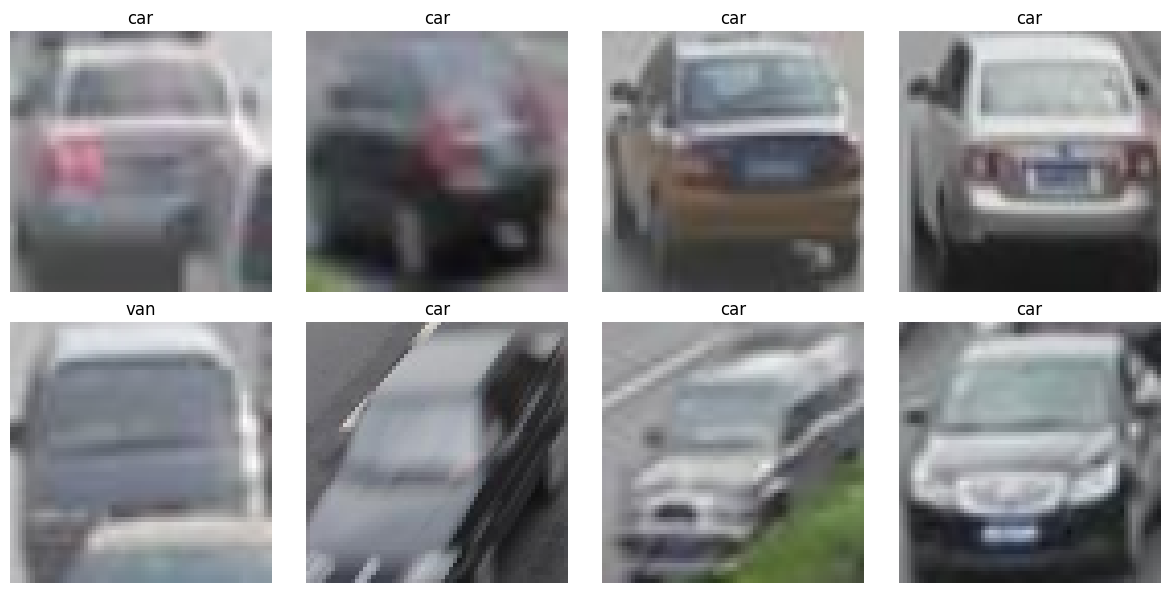

In [5]:
import random
idx_to_class = {v: k for k, v in class_to_idx.items()}

n_show = 8
indices = random.sample(range(len(images)), k=n_show)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for ax, i in zip(axes, indices):
    ax.imshow(images[i])
    label = labels[i]
    ax.set_title(idx_to_class[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

## 3. Summary

- Generated a cropped vehicle classification dataset from UA-DETRAC:
  - Total samples: `N =` _(see above output)_
  - Image size: `64 × 64 × 3`
  - Classes: car, bus, van, truck, etc.
- Saved the dataset to `outputs/cropped_vehicle_dataset.npz`.

Next step: train a CNN classifier using this dataset (Notebook 03).